In [139]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from matplotlib import animation
from aicsimageio import AICSImage as imio
from alive_progress import alive_bar
import cv2
from ipywidgets import interact
import ipywidgets as widgets

In [140]:
sourcepath = "C:\\Temp\\Testdata\\AF\\2.5inch_LaserDiode\\20231023_2.5inch_50um_1um_2ms\\stack\\stack_MMStack_Default.ome.tif"

In [141]:
datavol = np.asarray(np.squeeze(imio(sourcepath).data.copy()),dtype=np.int64)
minproj = np.min(datavol,axis=0)

<tifffile.TiffPage 0 @13951> <tifffile.TiffTag 50839 @14133> invalid value offset 0
<tifffile.TiffPage 0 @13951> <tifffile.TiffTag 50839 @14133> invalid value offset 0
<tifffile.TiffPage 0 @13951> <tifffile.TiffTag 50839 @14133> invalid value offset 0
<tifffile.TiffPage 0 @13951> <tifffile.TiffTag 50839 @14133> invalid value offset 0
<tifffile.read_micromanager_metadata> failed to read display settings: invalid display_header 0
<tifffile.TiffPages @13951> invalid page offset 321139304
<tifffile.TiffPage 0 @13951> <tifffile.TiffTag 50839 @14133> invalid value offset 0
<tifffile.read_micromanager_metadata> failed to read display settings: invalid display_header 0
<tifffile.TiffPages @13951> invalid page offset 321139304
<tifffile.TiffPage 0 @13951> <tifffile.TiffTag 50839 @14133> invalid value offset 0
<tifffile.read_micromanager_metadata> failed to read display settings: invalid display_header 0
<tifffile.TiffPages @13951> invalid page offset 321139304


In [142]:
def project(method, which_axis, data):
    proj = None
    dirn = 0
    match which_axis:
        case "X":
            dirn = 0
        case "Y":
            dirn = 1
        case _:
            dirn = 0
    match method:
        case "min":
            proj = np.min(data,axis=dirn)
        case "max":
            proj = np.max(data,axis=dirn)
        case "mean":
            proj = np.mean(data,axis=dirn)
        case "sum":
            proj = np.sum(data,axis=dirn)
    return proj

In [143]:
def proj_process(method,which_axis,stack):
    slices = range(np.shape(stack)[0])
    sequence=[]
    for slicenum in slices:
        sequence.append(project(method,which_axis,stack[slicenum,:,:]))
    return sequence

In [155]:
def getroots_FWHM(vect):
    peak = max(vect)
    vall = min(vect)
    spline = sp.interpolate.UnivariateSpline(np.arange(0,int(len(vect)),1), vect-((peak+vall)/2), s=0)
    roots = spline.roots()
    #print(roots)
    return np.min(roots),np.max(roots)

In [162]:
def rescale(np_arr_in,new_min,new_max):
    rescaled = ((new_max-new_min)*(np_arr_in-np.min(np_arr_in))/((np.max(np_arr_in)-np.min(np_arr_in))))+new_min
    return rescaled
    
def overlay_proj(fig,ax,imgpixels_ref,methods,colours,image,xplt,yplt,extra_line):
    scaling_frac = 0.4
    idx = 0;
    #plt.clf()
    for method in methods:
        imgpixels_ref.set_array(image)
        #imgpixels_ref.set_clim(0,5000)
        scaled_x_profile = rescale(project(method,"X",image),0,scaling_frac*n_x_px)
        scaled_y_profile = rescale(project(method,"Y",image),0,scaling_frac*n_y_px)
        xplt.set_ydata(scaled_x_profile)
        yplt.set_xdata(scaled_y_profile)
        idx = idx+1
    plt.draw()

# Explanation
Loaded raw images are processed as follows:

Temporary placeholder figure is set up
## proc_img runs on the slice
- Selected slice taken from volume (slicenum)
- Squaring is done if tickbox selected (square_it)
- Adaptive smoothing is done if tickbox selected (adaptive_smooth)
    - needs more control
- Gaussian blur is done (gblur_x and asp_ratio used)
    - may want to add an override for the zero width case?
- Overlay projection image is set to the processed output image
- Slice indicator position (dotted line on the metric graph)
- Colourscale limit is set
## eval_img is run on the processed image as part of Proc_img
- metric scaling default is set to 100
    - shouldn't affect things now that normalisation is done?
- Calculations done on % of brightest pixels (pct_brightest)
    - If % brightest is below -1e5, then this metric is not used - not zero due to floating point bullshit
    - If % brightest pixels (pct_brightest) is set above 1e-5, then the metric value is calculated from that fraction of brightest pixels, otherwise the single brightest pixel is used
- Projection is carried out using the specified method (method), along the selected axis (which_axis)
- Savitzky-Golay filter is applied with selected width (savgol) if number of points >0
- Fourier power spectrum is obtained with selected median filter width (FFT_median) if number of points >0
- Roots are obtained, and the difference between highest and lowest is returned
    - This will lead to issues with cases of >2 roots, but hopefully this will usually be rare...

GridspecLayout(children=(IntSlider(value=25, description='Slice', layout=Layout(grid_area='widget001'), max=50…

Output()

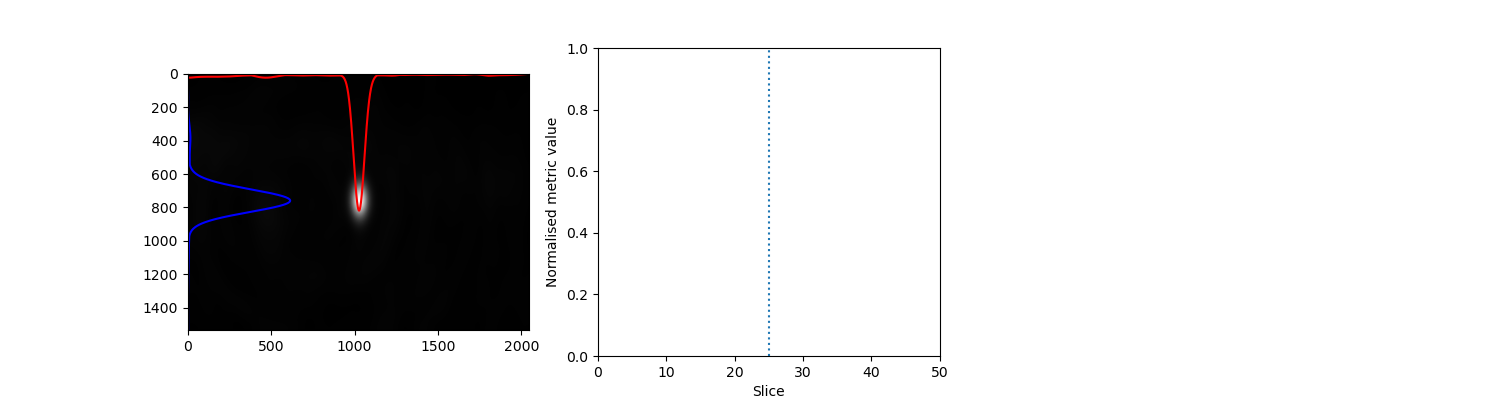

In [164]:
%matplotlib widget

targ_ax = "Y"

tmp_img = datavol[0,:,:]
lin_vmax = np.max(datavol)
sq_vmax = lin_vmax*lin_vmax

nslices = datavol.shape[0]

# Setup for live plot
fig_1 = plt.figure(figsize=(15,4))
f_1A = fig_1.add_subplot(1,3,1)
imgpixels_ref = f_1A.imshow(tmp_img,cmap='gray',vmin=0,vmax=np.max(tmp_img))
n_y_px,n_x_px = tmp_img.shape[0],tmp_img.shape[1]
scaling_frac = 0.4

scaled_x_profile = rescale(project("max","X",tmp_img),0,scaling_frac*n_x_px)
scaled_y_profile = rescale(project("max","Y",tmp_img),0,scaling_frac*n_y_px)
xplt, = f_1A.plot(scaled_x_profile,color='r')
#Little fudge to get the plot along y-x, not x-y
yplt, = f_1A.plot(scaled_y_profile,color='b')
newy = yplt.get_xdata()
newx = yplt.get_ydata()
yplt.set_xdata(newx)
yplt.set_ydata(newy)

#Setup for processed plot
f_1B = fig_1.add_subplot(1,3,2)
f_1B.set_xlim(0,nslices-1)
f_1B.set_xlabel("Slice")
f_1B.set_ylabel("Normalised metric value")
slice_indicator = f_1B.axvline(0,0,1,linestyle=":")

#Interactions
dummy_line = []
overlay_proj(fig_1,f_1A,imgpixels_ref,["max","mean"],["r","b"],tmp_img,xplt,yplt,dummy_line)

arb_max = 100

slicenum = widgets.IntSlider(description="Slice", min=0, max=nslices-1, value=25)
gblur_x = widgets.IntSlider(description="Gblur size x", min=1, max=(2*int(datavol.shape[1]/4))+1, step=2, value=201)
asp_ratio = widgets.FloatSlider(description="Blur aspect ratio", min = 0, max = 5, step=0.05, value=2)
square_it = widgets.Checkbox(False, description='Square it')
scale_it = widgets.Checkbox(True, description='Scale display intensity')
targ_ax = widgets.Dropdown(options=["X","Y"], description='Axis')
proj_meth = widgets.Dropdown(options=["max","min","mean"], description='Method')
adaptive_smooth = widgets.Checkbox(False, description='Use adaptive smoothing')
int_pct = widgets.FloatSlider(description="Use % brightest", min=-2e-2, max=1e-1, step=1e-3, value=-2e-2, readout_format='.3e')
savgol = widgets.IntSlider(description="S-G filter", min=-1, max=arb_max, value=5, stpe = 2)
FFT_median = widgets.IntSlider(description="FFT median filter", min=-1, max=arb_max, value=5, step = 2)
run_proc = widgets.Button(description = 'Process all slices')

nrows = 4
ncols = 3
control_list = [slicenum, gblur_x, asp_ratio, square_it, scale_it, targ_ax, proj_meth, adaptive_smooth, savgol, FFT_median, int_pct, run_proc]
grid = widgets.GridspecLayout(nrows, ncols)
for i in range(nrows):
    for j in range(ncols):
        if((ncols*i)+j<len(control_list)):
            grid[i, j] = control_list[(ncols*i)+j]
ui = grid
#ui = widgets.GridBox ([slicenum, gblur_x, asp_ratio, square_it, scale_it, targ_ax, run_proc])

def eval_img(method,which_axis,img_in,pct_brightest,savgol,FWHM_medfilt_scale):
    met_val = 0 # default
    met_scale=100
    linearised = np.ravel(img_in)
    n_biggest_elems = int(pct_brightest*linearised.size)
    proj_line = None
    #print(pct_brightest,n_biggest_elems)
    if(pct_brightest>=-1e-5):
        if(pct_brightest<1e-5):
            met_val = (met_scale*(np.max(img_in)/lin_vmax))
        else:
            big_indices = np.argpartition(linearised, -n_biggest_elems)[-n_biggest_elems:]
            bigvals = linearised[big_indices]
            met_val = met_scale*np.sum(bigvals)/(n_biggest_elems*lin_vmax)#bad to use predefined vmax - make it an input!
    else:
        proj_line = project(method,which_axis,img_in)
        if(savgol>0):
            proj_line = sp.ndimage.uniform_filter1d(proj_line,size=savgol, mode='nearest')
        if(FWHM_medfilt_scale>0):
            proj_line = np.roll(np.abs(np.fft.fft(proj_line)),int(len(proj_line)/2))
            proj_line = sp.signal.medfilt(proj_line,FWHM_medfilt_scale)
        #Do this before 2D trickery
        min,max = getroots_FWHM(proj_line)
        proj_line = [proj_line]
        if(which_axis == "Y"):
            proj_line = proj_line.T
        met_val = max-min
    return met_val, proj_line

def proc_img(slicenum, gblur_x, asp_ratio, square_it, scale_it, targ_ax, proj_meth, int_pct,savgol, FFT_median):
    rawslice = datavol[slicenum,:,:]
    #Switch to using output_image
    output_image = rawslice 
    #Square if requested
    rangemax = lin_vmax
    if(square_it == True):
        output_image = np.square(output_image)
        rangemax = sq_vmax
    if(adaptive_smooth == True):
        gblur_x = int((gblur_x*rangemax)/2*np.max(output_image))
    #Blur
    gblur_y = int(gblur_x*asp_ratio)
    if(gblur_y%2==0):
        gblur_y = gblur_y+1
    output_image = cv2.GaussianBlur(np.float32(output_image), (gblur_x,gblur_y),0,0)#.astype(np.int32)
    #Process
    metric, line = eval_img(proj_meth,targ_ax,np.squeeze(output_image),int_pct,savgol,FFT_median)
    #Update display
    overlay_proj(fig_1,f_1A,imgpixels_ref,[proj_meth],["r","b"],output_image,xplt,yplt,line)
    #Add indicators
    slice_indicator.set_data([slicenum],[0,1])
    if(line != None):
        pass
        #Add second overlay?
    #Scale display
    if(scale_it == True):
        imgpixels_ref.set_clim(np.min(output_image),np.max(output_image))
    else:
        imgpixels_ref.set_clim(0,rangemax)
    return metric
   
@run_proc.on_click
def dclick(run_proc):
    with alive_bar(nslices,force_tty=True, title = "Processing metric") as metric_progbar:
        proc_method="Evaluations"
        f_1B.set_title(proc_method)
        metric = []
        settings=targ_ax.value+", "
        for slice in range(nslices):
            metric.append(proc_img(slice, gblur_x.value, asp_ratio.value, square_it.value, scale_it.value, targ_ax.value, proj_meth.value, int_pct.value,savgol.value,FFT_median.value))
            metric_progbar()
        if(square_it.value==True):
            settings += "Squared, "
        if(adaptive_smooth.value==True):
            settings+="Adaptive"
        else:
            settings+="G_x: "+str(gblur_x.value)+", G_asp: "+str(asp_ratio.value)
        if(int_pct.value>=0):
            n_px = int((int_pct.value)*datavol[slice,:,:].size)
            settings="Intensity-based, "+str(n_px)+" px"
        scaled_metric = (metric - np.min(metric)) / (np.max(metric) - np.min(metric))
        f_1B.plot(scaled_metric,label=settings)
        f_1B.legend()

out = widgets.interactive_output(proc_img, {'slicenum': slicenum, 'gblur_x': gblur_x, 'asp_ratio': asp_ratio, 'square_it':square_it, 'scale_it':scale_it, 'targ_ax':targ_ax, 'proj_meth':proj_meth, 'int_pct':int_pct, 'savgol':savgol ,'FFT_median':FFT_median})
display(ui, out)

In [131]:
slice.size

3145728